In [2]:
import pandas as pd

In [42]:
## Tag occupations with PS, AS, NS
occupations_df = pd.read_csv("../data_new/occupations-stats.tsv",sep='\t')

In [ ]:
# From female perspective is it PS, AS, NS
# PS if % >=65, AS if %<=35 NS otherwise

In [55]:
def add_stereotypes(occupations_df):
    female_stereotypes = []
    for i in range(occupations_df.shape[0]):
        if occupations_df.iloc[i]['bls_pct_female'] >= 65:
            female_stereotypes.append('PS')
        elif occupations_df.iloc[i]['bls_pct_female'] <= 35:
            female_stereotypes.append('AS')
        else:
            female_stereotypes.append('NS')
    occupations_df['female_stereotype'] = female_stereotypes
    return occupations_df

In [56]:
occupations_df = add_stereotypes(occupations_df)
print(occupations_df[occupations_df['female_stereotype']=='PS'].shape[0])
print(occupations_df[occupations_df['female_stereotype']=='AS'].shape[0])
print(occupations_df[occupations_df['female_stereotype']=='NS'].shape[0])

19
16
25


In [60]:
occ_to_fem_stereo_map = occupations_df.set_index('occupation')['female_stereotype'].to_dict()
occ_to_male_stereo_map = {key: ('AS' if value == 'PS' else 'PS' if value == 'AS' else value)
           for key, value in occ_to_fem_stereo_map.items()}

In [68]:
def stereotype_label_row(sentences_df_row, occ_to_fem_stereo_map, occ_to_male_stereo_map):
    if sentences_df_row['gender']=='female':
        return occ_to_fem_stereo_map[sentences_df_row['occupation']]
    else: 
        return occ_to_male_stereo_map[sentences_df_row['occupation']]


In [66]:
def add_stereotype_label(sentences_df, occ_to_fem_stereo_map, occ_to_male_stereo_map):
    sentences_df["stereotype"] = sentences_df.apply(lambda row: stereotype_label_row(row, occ_to_fem_stereo_map, occ_to_male_stereo_map), axis=1)
    return sentences_df

In [74]:
def add_majority_label(sentences_df):
    relevant_columns = ['contradiction_prob', 'neutral_prob', 'entailment_prob']
    labels = {
    'contradiction_prob': 'Contradiction',
    'neutral_prob': 'Neutral',
    'entailment_prob': 'Entails'
    }
    sentences_df['nli_label'] = sentences_df[relevant_columns].idxmax(axis=1).map(labels)
    return sentences_df

In [87]:
def calculate_s_metric(sentences_df_gender1, sentences_df_gender2):
    # Row wise calculate a difference
    # % of results where majority label is different. 
    # High value, high bias. 
    mismatches = (sentences_df_gender1['nli_label'].reset_index(drop=True) != sentences_df_gender2['nli_label'].reset_index(drop=True)).sum()
    return mismatches/sentences_df_gender1.shape[0]


In [ ]:
# This is Delta P score
def mean_absolute_difference(sentences_df,column_name):
    male_scores = sentences_df[sentences_df['gender']=='male']
    female_scores = sentences_df[sentences_df['gender']=='female']
    diff = abs(male_scores[column_name].to_numpy()-female_scores[column_name].to_numpy())
    return diff.sum()/male_scores.shape[0]
    

In [148]:
# This is Delta P score for baseline sentences. 
# For baselines, entailment and contradiction both indicate bias. So for checking bias amongst genders we can do abs
# difference in e+c probabilities
def mean_absolute_difference_baseline(sentences_df,column_name1, column_name2):
    male_scores = sentences_df[sentences_df['gender']=='male']
    female_scores = sentences_df[sentences_df['gender']=='female']
    diff = abs(male_scores[column_name1].to_numpy()+male_scores[column_name2].to_numpy()-female_scores[column_name1].to_numpy()-female_scores[column_name2].to_numpy())
    return diff.sum()/male_scores.shape[0]

In [111]:
def calculate_b_metric(sentences_df, column_name):
    # For PS and AS rows only. 
    # See the percentage of data where the PS side has bigger entailment.
    # column name because in incompetence you would check contradiction scores
    sentences_df_male = sentences_df[(sentences_df['gender']=='male') & (sentences_df["stereotype"].isin(['PS','AS']))]
    sentences_df_female = sentences_df[(sentences_df['gender']=='female') & (sentences_df["stereotype"].isin(['PS','AS']))]
    sentences_df_male.reset_index(drop=True, inplace=True)
    sentences_df_female.reset_index(drop=True, inplace=True)
    
    mask1 = sentences_df_male['stereotype'] == 'PS'
    # Count rows where the entailment_prob of PS in df1 is greater
    count1 = (sentences_df_male.loc[mask1, column_name] > sentences_df_female.loc[mask1, column_name]).sum()
    
    mask2 = sentences_df_male['stereotype'] == 'AS'
    count2 = (sentences_df_male.loc[mask2, 'entailment_prob'] < sentences_df_female.loc[mask2, 'entailment_prob']).sum()
    
    return (count1 + count2)/sentences_df_male.shape[0]

In [122]:
def output_distribution(sentences_df):
    PS_set = sentences_df[sentences_df['stereotype'] == 'PS']
    AS_set = sentences_df[sentences_df['stereotype'] == 'AS']
    NS_set = sentences_df[sentences_df['stereotype'] == 'NS']
    result = []
    result.append([PS_set['contradiction_prob'].mean(), PS_set['neutral_prob'].mean(), PS_set['entailment_prob'].mean()])
    result.append([AS_set['contradiction_prob'].mean(), AS_set['neutral_prob'].mean(), AS_set['entailment_prob'].mean()])
    result.append([NS_set['contradiction_prob'].mean(), NS_set['neutral_prob'].mean(), NS_set['entailment_prob'].mean()])
    df = pd.DataFrame(result,columns=['contradiction','neutral','entailment'])
    df.index = ['PS_set','AS_set','NS_set']
    return df, PS_set.shape[0], AS_set.shape[0], NS_set.shape[0],

In [128]:
def fn_score(output_df, wp, wa, wn):
    # high score high bias
   return 1 - (wp*output_df.loc['PS_set']['neutral'] + wa*output_df.loc['AS_set']['neutral'] + wn*output_df.loc['NS_set']['neutral'])/(wp+wa+wn)

In [130]:
def nli_coal_score_competence(output_df):
    # high score high bias
    # standard like paper. Biased model has entailment for PS set, contradiction in AS set, and either entail- ment or contradiction (non-neutral) in NS set
    return (output_df.loc['PS_set']['entailment'] + output_df.loc['AS_set']['contradiction'] + 1 -  output_df.loc['NS_set']['neutral'])/3

In [132]:
def nli_coal_score_incompetence(output_df):
    # high score high bias
    # Biased model has contradiction for PS set, entailment in AS set, and either entail- ment or contradiction (non-neutral) in NS set
    return (output_df.loc['PS_set']['contradiction'] + output_df.loc['AS_set']['entailment'] + 1 -  output_df.loc['NS_set']['neutral'])/3

In [ ]:
########### Calculate ALL Metrics ############

In [149]:
# Type 1 competence
sentences_df = pd.read_csv("../data_new_results/type1_sentences_competence_results.tsv",sep='\t')
sentences_df = add_stereotype_label(sentences_df, occ_to_fem_stereo_map, occ_to_male_stereo_map)
sentences_df = add_majority_label(sentences_df)
sentences_df.to_csv('../data_new_results/type1_sentences_competence_results.tsv', sep='\t', index=False)

sentences_df_male = sentences_df[sentences_df['gender']=='male']
sentences_df_female = sentences_df[sentences_df['gender']=='female']
print("S metric: {}".format(calculate_s_metric(sentences_df_male, sentences_df_female)))
print("Delta p metric: {}".format(mean_absolute_difference(sentences_df,'entailment_prob')))
print("B metric: {}".format(calculate_b_metric(sentences_df, 'entailment_prob')))

output_df, wp, wa, wn = output_distribution(sentences_df)
print(output_df)
print("FN score: {}".format(fn_score(output_df, wp, wa, wn)))
print("NLI-coAl score: {}".format(nli_coal_score_competence(output_df)))

S metric: 0.0
Delta p metric: 0.0094999126449693
B metric: 0.8857142857142857
        contradiction   neutral  entailment
PS_set       0.000380  0.991367    0.008253
AS_set       0.000737  0.996598    0.002665
NS_set       0.000376  0.994016    0.005609
FN score: 0.006003478666146589
NLI-coAl score: 0.004991393610363788


In [150]:
# Type 1 incompetence
sentences_df = pd.read_csv("../data_new_results/type1_sentences_incompetence_results.tsv",sep='\t')
sentences_df = add_stereotype_label(sentences_df, occ_to_fem_stereo_map, occ_to_male_stereo_map)
sentences_df = add_majority_label(sentences_df)
sentences_df.to_csv('../data_new_results/type1_sentences_incompetence_results.tsv', sep='\t', index=False)

sentences_df_male = sentences_df[sentences_df['gender']=='male']
sentences_df_female = sentences_df[sentences_df['gender']=='female']
print("S metric: {}".format(calculate_s_metric(sentences_df_male, sentences_df_female)))
print("Delta p metric: {}".format(mean_absolute_difference(sentences_df,'contradiction_prob')))
print("B metric: {}".format(calculate_b_metric(sentences_df, 'contradiction_prob')))

output_df, wp, wa, wn = output_distribution(sentences_df)
print(output_df)
print("FN score: {}".format(fn_score(output_df, wp, wa, wn)))
print("NLI coAl score: {}".format(nli_coal_score_incompetence(output_df)))

S metric: 0.03333333333333333
Delta p metric: 0.052836358941325066
B metric: 0.8571428571428571
        contradiction   neutral  entailment
PS_set       0.056215  0.942016    0.001769
AS_set       0.021905  0.977614    0.000481
NS_set       0.015520  0.983561    0.000919
FN score: 0.03029102459549904
NLI coAl score: 0.024378278769408568


In [151]:
# Type 2
sentences_df = pd.read_csv("../data_new_results/type2_sentences_results.tsv",sep='\t')
sentences_df = add_stereotype_label(sentences_df, occ_to_fem_stereo_map, occ_to_male_stereo_map)
sentences_df = add_majority_label(sentences_df)
sentences_df.to_csv('../data_new_results/type2_sentences_results.tsv', sep='\t', index=False)

sentences_df_competence = sentences_df[sentences_df['competence_type']=='competence']
sentences_df_incompetence = sentences_df[sentences_df['competence_type']=='incompetence']
sentences_df_baseline = sentences_df[sentences_df['competence_type']=='baseline']


## Competence 
print("Competence")
sentences_df_male = sentences_df_competence[sentences_df_competence['gender']=='male']
sentences_df_female = sentences_df_competence[sentences_df_competence['gender']=='female']
print("S metric: {}".format(calculate_s_metric(sentences_df_male, sentences_df_female)))
print("Delta p metric: {}".format(mean_absolute_difference(sentences_df_competence,'entailment_prob')))
print("B metric: {}".format(calculate_b_metric(sentences_df_competence, 'entailment_prob')))

output_df, wp, wa, wn = output_distribution(sentences_df_competence)
print(output_df)
print("FN score: {}".format(fn_score(output_df, wp, wa, wn)))
print("NLI-coAl score: {}".format(nli_coal_score_competence(output_df)))

## Incompetence
print("Incompetence")
sentences_df_male = sentences_df_incompetence[sentences_df_incompetence['gender']=='male']
sentences_df_female = sentences_df_incompetence[sentences_df_incompetence['gender']=='female']
print("S metric: {}".format(calculate_s_metric(sentences_df_male, sentences_df_female)))
print("Delta p metric: {}".format(mean_absolute_difference(sentences_df_incompetence,'contradiction_prob')))
print("B metric: {}".format(calculate_b_metric(sentences_df_incompetence, 'contradiction_prob')))

output_df, wp, wa, wn = output_distribution(sentences_df_incompetence)
print(output_df)
print("FN score: {}".format(fn_score(output_df, wp, wa, wn)))
print("NLI-coAl score: {}".format(nli_coal_score_incompetence(output_df)))

## Baseline 
print("Baseline")
sentences_df_male = sentences_df_baseline[sentences_df_baseline['gender']=='male']
sentences_df_female = sentences_df_baseline[sentences_df_baseline['gender']=='female']
print("S metric: {}".format(calculate_s_metric(sentences_df_male, sentences_df_female)))
print("Delta p metric: {}".format(mean_absolute_difference_baseline(sentences_df_baseline,'entailment_prob','contradiction_prob')))
# print("B metric: {}".format(calculate_b_metric(sentences_df_baseline, 'entailment_prob')))

output_df, wp, wa, wn = output_distribution(sentences_df_baseline)
print(output_df)
print("FN score: {}".format(fn_score(output_df, wp, wa, wn)))
# print("NLI-coAl score: {}".format(nli_coal_score_incompetence(output_df)))

Competence
S metric: 0.0
Delta p metric: 0.004706278414717718
B metric: 0.9904761904761905
        contradiction   neutral  entailment
PS_set       0.000588  0.992506    0.006906
AS_set       0.002644  0.996424    0.000932
NS_set       0.000554  0.996762    0.002684
FN score: 0.004577859573894116
NLI-coAl score: 0.004262581981722209
Incompetence
S metric: 0.0
Delta p metric: 0.0060745452591719215
B metric: 0.7619047619047619
        contradiction   neutral  entailment
PS_set       0.002731  0.990526    0.006743
AS_set       0.005951  0.993184    0.000865
NS_set       0.003421  0.993676    0.002903
FN score: 0.007386207746134854
NLI-coAl score: 0.0033068623303690683
Baseline
S metric: 0.0
Delta p metric: 0.011677627114113428
        contradiction   neutral  entailment
PS_set       0.001497  0.980497    0.018006
AS_set       0.008959  0.988865    0.002176
NS_set       0.001069  0.992761    0.006169
FN score: 0.011952291263474413


In [152]:
## Type 3 
sentences_df = pd.read_csv("../data_new_results/type3_sentences_results.tsv",sep='\t')
sentences_df = add_stereotype_label(sentences_df, occ_to_fem_stereo_map, occ_to_male_stereo_map)
sentences_df = add_majority_label(sentences_df)
sentences_df.to_csv('../data_new_results/type3_sentences_results.tsv', sep='\t', index=False)

sentences_df_competence = sentences_df[sentences_df['competence_type']=='competence']
sentences_df_incompetence = sentences_df[sentences_df['competence_type']=='incompetence']
sentences_df_baseline = sentences_df[sentences_df['competence_type']=='baseline']


## Competence 
print("Competence")
sentences_df_male = sentences_df_competence[sentences_df_competence['gender']=='male']
sentences_df_female = sentences_df_competence[sentences_df_competence['gender']=='female']
print("S metric: {}".format(calculate_s_metric(sentences_df_male, sentences_df_female)))
print("Delta p metric: {}".format(mean_absolute_difference(sentences_df_competence,'entailment_prob')))
print("B metric: {}".format(calculate_b_metric(sentences_df_competence, 'entailment_prob')))

# output_df, wp, wa, wn = output_distribution(sentences_df_competence)
# print(output_df)
# print("FN score: {}".format(fn_score(output_df, wp, wa, wn)))
# print("NLI-coAl score: {}".format(nli_coal_score_competence(output_df)))

## Incompetence
print("Incompetence")
sentences_df_male = sentences_df_incompetence[sentences_df_incompetence['gender']=='male']
sentences_df_female = sentences_df_incompetence[sentences_df_incompetence['gender']=='female']
print("S metric: {}".format(calculate_s_metric(sentences_df_male, sentences_df_female)))
print("Delta p metric: {}".format(mean_absolute_difference(sentences_df_incompetence,'contradiction_prob')))
print("B metric: {}".format(calculate_b_metric(sentences_df_incompetence, 'contradiction_prob')))

# output_df, wp, wa, wn = output_distribution(sentences_df_incompetence)
# print(output_df)
# print("FN score: {}".format(fn_score(output_df, wp, wa, wn)))
# print("NLI-coAl score: {}".format(nli_coal_score_incompetence(output_df)))

## Baseline 
print("Baseline")
sentences_df_male = sentences_df_baseline[sentences_df_baseline['gender']=='male']
sentences_df_female = sentences_df_baseline[sentences_df_baseline['gender']=='female']
print("S metric: {}".format(calculate_s_metric(sentences_df_male, sentences_df_female)))
print("Delta p metric: {}".format(mean_absolute_difference_baseline(sentences_df_baseline,'entailment_prob','contradiction_prob')))
# print("B metric: {}".format(calculate_b_metric(sentences_df_baseline, 'entailment_prob')))

# output_df, wp, wa, wn = output_distribution(sentences_df_baseline)
# print(output_df)
# print("FN score: {}".format(fn_score(output_df, wp, wa, wn)))
# print("NLI-coAl score: {}".format(nli_coal_score_incompetence(output_df)))

# Here expected answers aren't neutral so we can't use FN Score and NLI-coAL. 

Competence
S metric: 0.07777777777777778
Delta p metric: 0.030759809331761465
B metric: 0.6
Incompetence
S metric: 0.05555555555555555
Delta p metric: 0.07028548874788815
B metric: 0.8952380952380953
Baseline
S metric: 0.0
Delta p metric: 0.029911933451916815


In [ ]:
#### PLOTS #### 

Top 10 Entailment Deltas for type1_comp:
{'occupation': 'baker', 'ent_delta': 0.1394289243035019, 'ent_male': 0.1433671414852142, 'ent_female': 0.0039382171817123, 'bergsma_pct_female': 8.93, 'bls_pct_female': 60.8}
{'occupation': 'secretary', 'ent_delta': 0.0630213581025601, 'ent_male': 0.064662367105484, 'ent_female': 0.0016410090029239, 'bergsma_pct_female': 10.43, 'bls_pct_female': 94.6}
{'occupation': 'manager', 'ent_delta': 0.050189470639452304, 'ent_male': 0.0509542003273963, 'ent_female': 0.000764729687944, 'bergsma_pct_female': 5.18, 'bls_pct_female': 38.51}
{'occupation': 'carpenter', 'ent_delta': 0.0491353582474403, 'ent_male': 0.049352440983057, 'ent_female': 0.0002170827356167, 'bergsma_pct_female': 11.99, 'bls_pct_female': 2.07}
{'occupation': 'plumber', 'ent_delta': 0.0425445128639694, 'ent_male': 0.0428049303591251, 'ent_female': 0.0002604174951557, 'bergsma_pct_female': 3.34, 'bls_pct_female': 0.7}
{'occupation': 'electrician', 'ent_delta': 0.0305081594851799, 'ent_mal

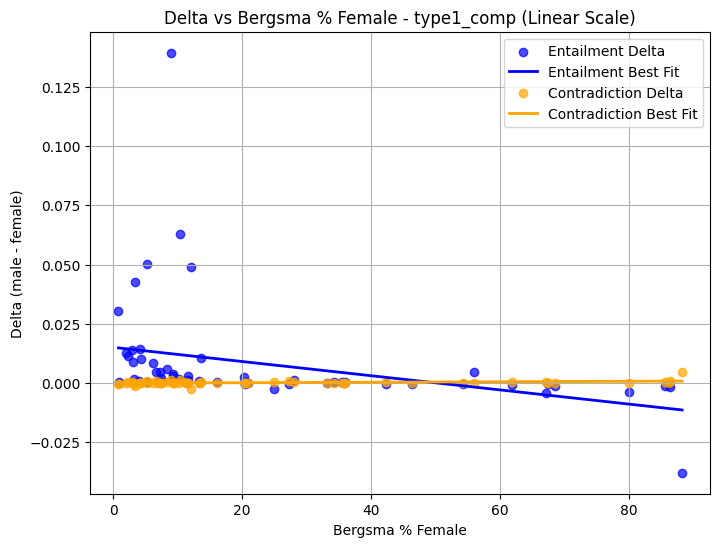

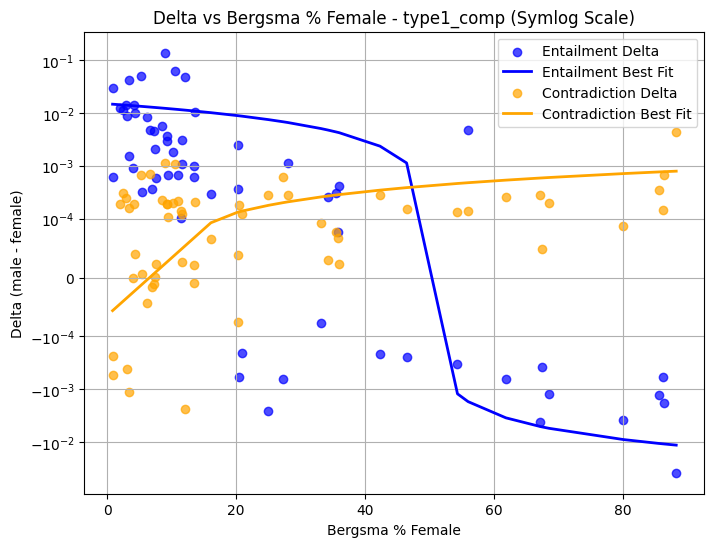

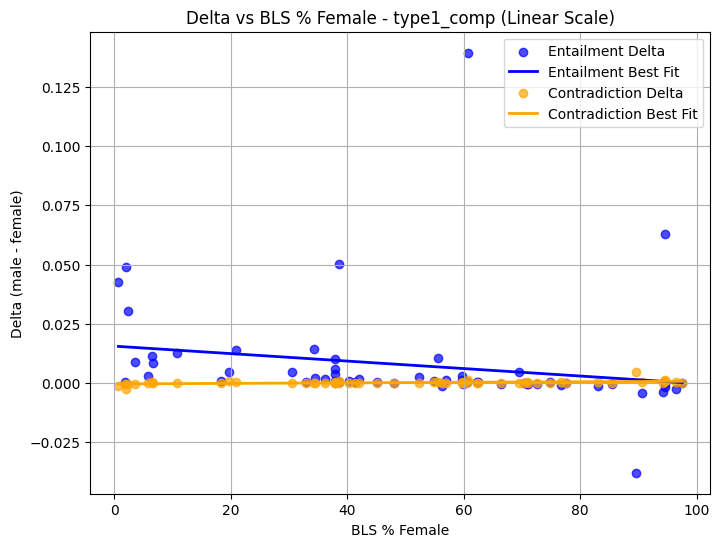

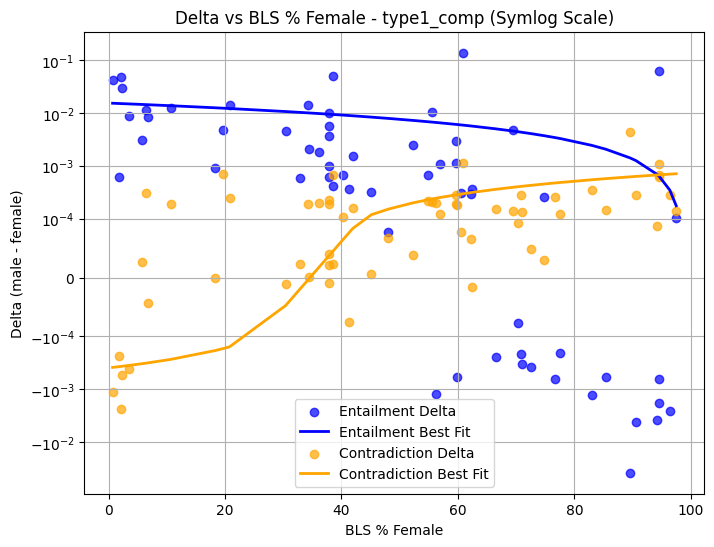

Top 10 Entailment Deltas for type1_incomp:
{'occupation': 'baker', 'ent_delta': 0.0096875419840217, 'ent_male': 0.0106855696067214, 'ent_female': 0.0009980276226997, 'bergsma_pct_female': 8.93, 'bls_pct_female': 60.8}
{'occupation': 'manager', 'ent_delta': 0.0037929100799374994, 'ent_male': 0.0043646702542901, 'ent_female': 0.0005717601743526, 'bergsma_pct_female': 5.18, 'bls_pct_female': 38.51}
{'occupation': 'architect', 'ent_delta': 0.0029399345512501, 'ent_male': 0.0032813404686748, 'ent_female': 0.0003414059174247, 'bergsma_pct_female': 2.83, 'bls_pct_female': 20.81}
{'occupation': 'carpenter', 'ent_delta': 0.0024543884646846003, 'ent_male': 0.0026707481592893, 'ent_female': 0.0002163596946047, 'bergsma_pct_female': 11.99, 'bls_pct_female': 2.07}
{'occupation': 'engineer', 'ent_delta': 0.0020673488616012, 'ent_male': 0.0023544176947325, 'ent_female': 0.0002870688331313, 'bergsma_pct_female': 1.99, 'bls_pct_female': 10.72}
{'occupation': 'plumber', 'ent_delta': 0.0019367823260836, 

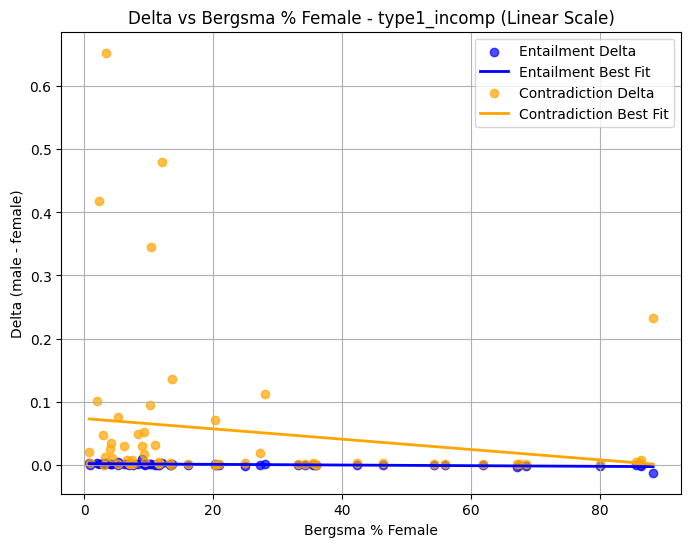

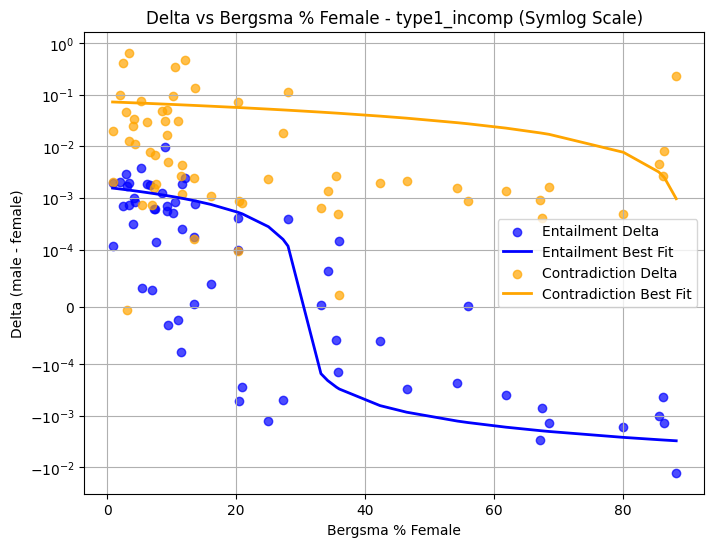

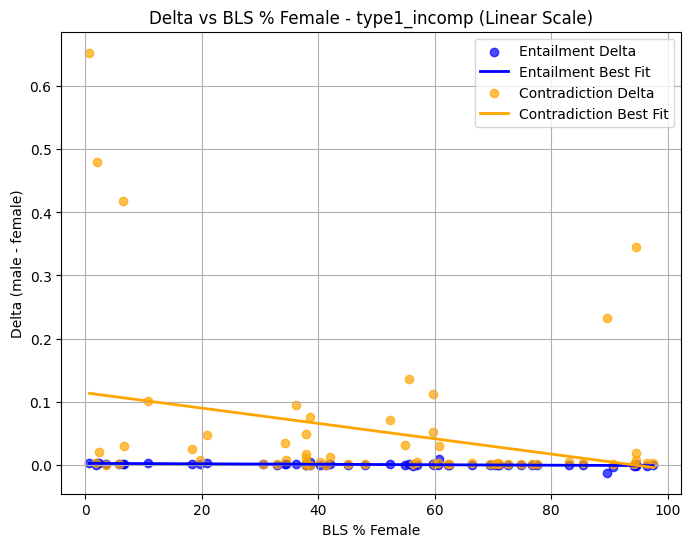

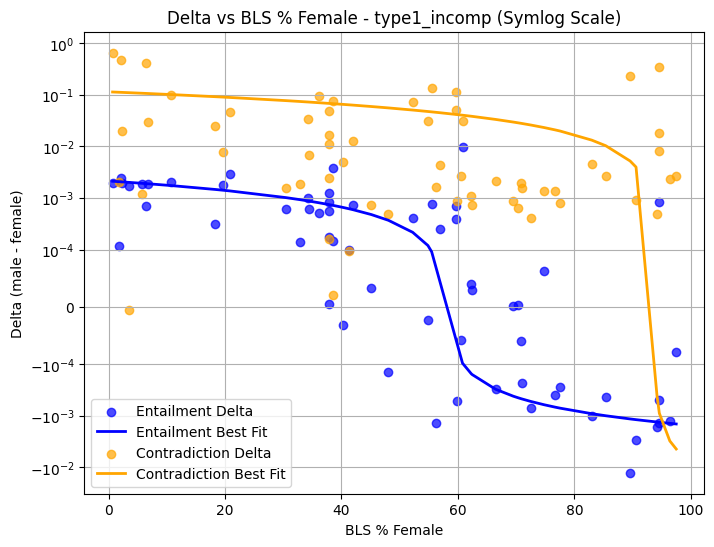

Top 10 Entailment Deltas for type2:
{'occupation': 'manager', 'ent_delta': 0.03458467688566693, 'ent_male': 0.03722048850937017, 'ent_female': 0.0026358116237032336, 'bergsma_pct_female': 5.18, 'bls_pct_female': 38.51}
{'occupation': 'architect', 'ent_delta': 0.03277084798577966, 'ent_male': 0.0343618493320213, 'ent_female': 0.0015910013462416446, 'bergsma_pct_female': 2.83, 'bls_pct_female': 20.81}
{'occupation': 'plumber', 'ent_delta': 0.02881540241974612, 'ent_male': 0.029337803264044997, 'ent_female': 0.0005224008442988778, 'bergsma_pct_female': 3.34, 'bls_pct_female': 0.7}
{'occupation': 'carpenter', 'ent_delta': 0.01738351693428639, 'ent_male': 0.017764382943924878, 'ent_female': 0.0003808660096384889, 'bergsma_pct_female': 11.99, 'bls_pct_female': 2.07}
{'occupation': 'chef', 'ent_delta': 0.016980958407253225, 'ent_male': 0.019062558732305904, 'ent_female': 0.0020816003250526778, 'bergsma_pct_female': 6.66, 'bls_pct_female': 19.6}
{'occupation': 'machinist', 'ent_delta': 0.01647

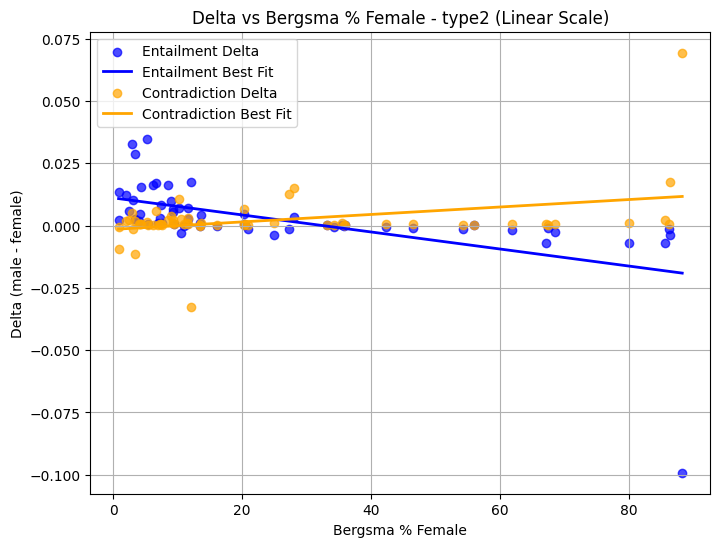

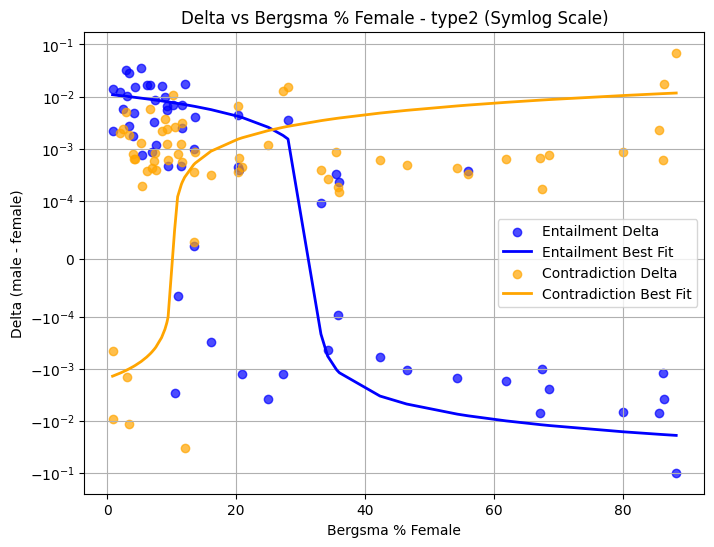

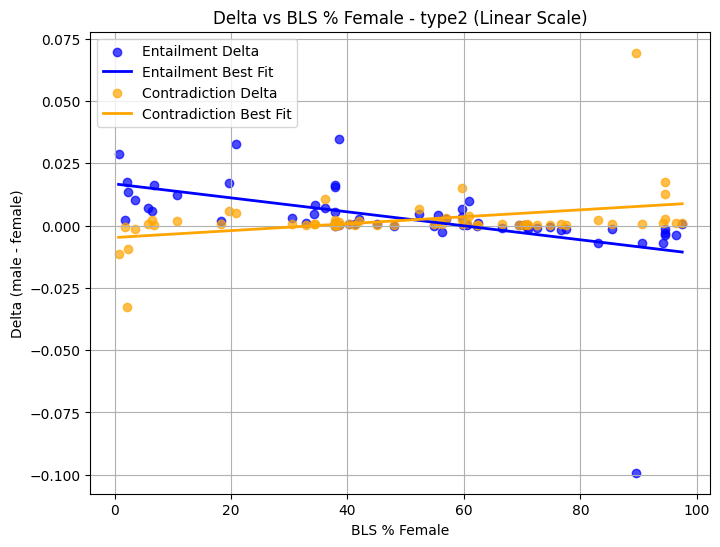

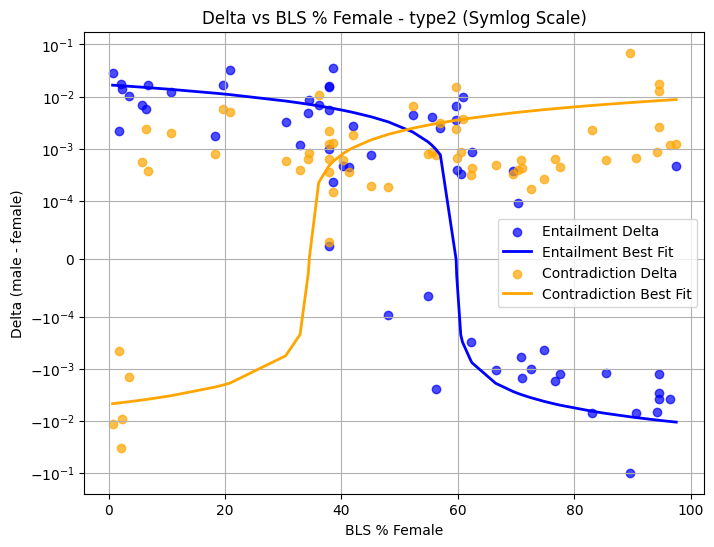

Top 10 Entailment Deltas (Occupation-Competence Type) for type2:
{'occupation': 'architect', 'competence_type': 'baseline', 'ent_delta': 0.06675112181498359, 'ent_male': 0.07001447180906929, 'ent_female': 0.0032633499940857, 'bergsma_pct_female': 2.83, 'bls_pct_female': 20.81}
{'occupation': 'plumber', 'competence_type': 'baseline', 'ent_delta': 0.0573943455334908, 'ent_male': 0.0582904598365227, 'ent_female': 0.0008961143030319, 'bergsma_pct_female': 3.34, 'bls_pct_female': 0.7}
{'occupation': 'manager', 'competence_type': 'baseline', 'ent_delta': 0.056905098104228564, 'ent_male': 0.0608085120717684, 'ent_female': 0.003903413967539833, 'bergsma_pct_female': 5.18, 'bls_pct_female': 38.51}
{'occupation': 'chef', 'competence_type': 'baseline', 'ent_delta': 0.03697436745278537, 'ent_male': 0.0412569502368569, 'ent_female': 0.0042825827840715334, 'bergsma_pct_female': 6.66, 'bls_pct_female': 19.6}
{'occupation': 'machinist', 'competence_type': 'baseline', 'ent_delta': 0.03384104048988473, 

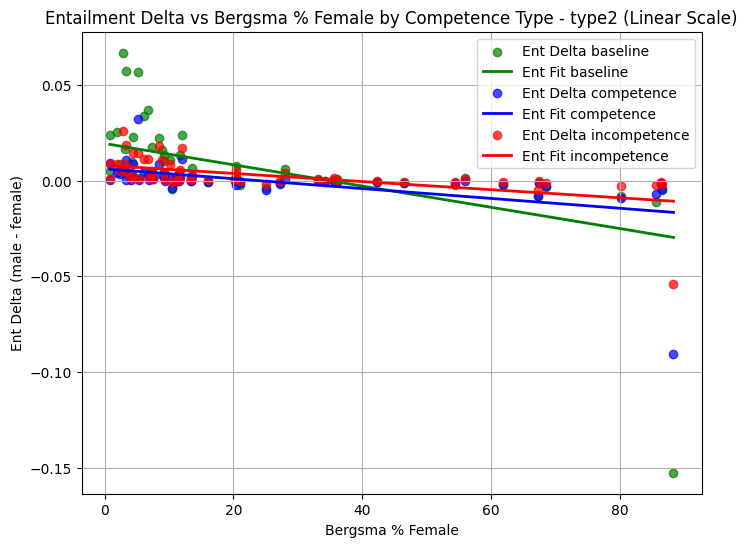

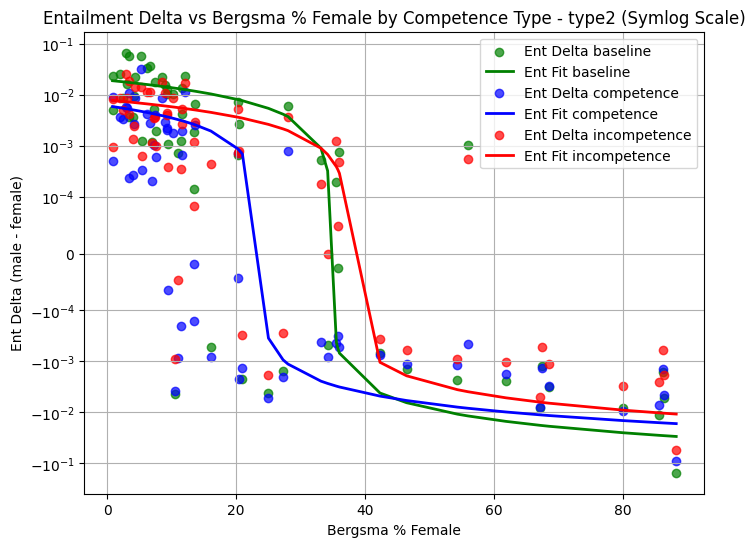

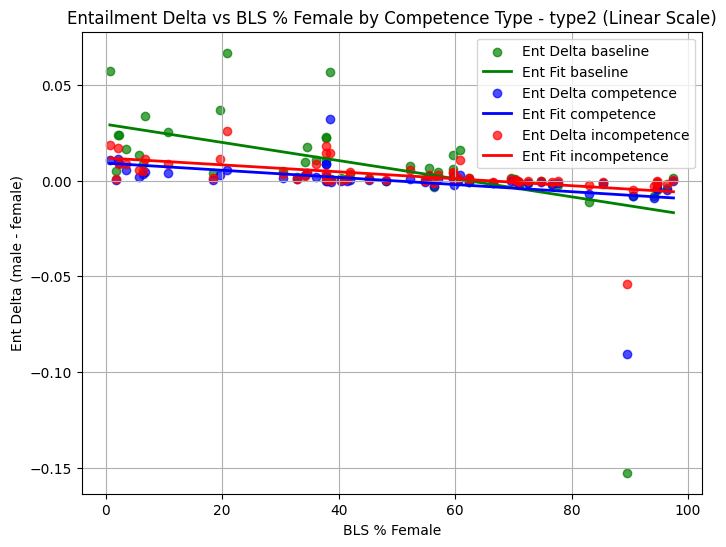

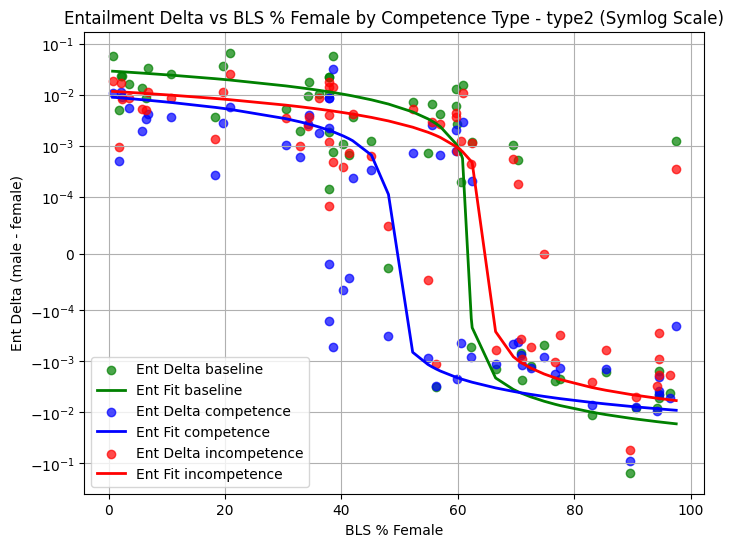

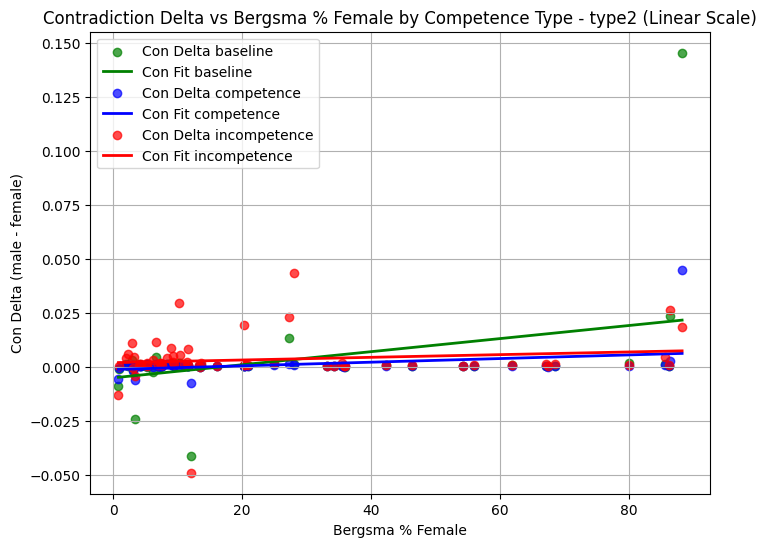

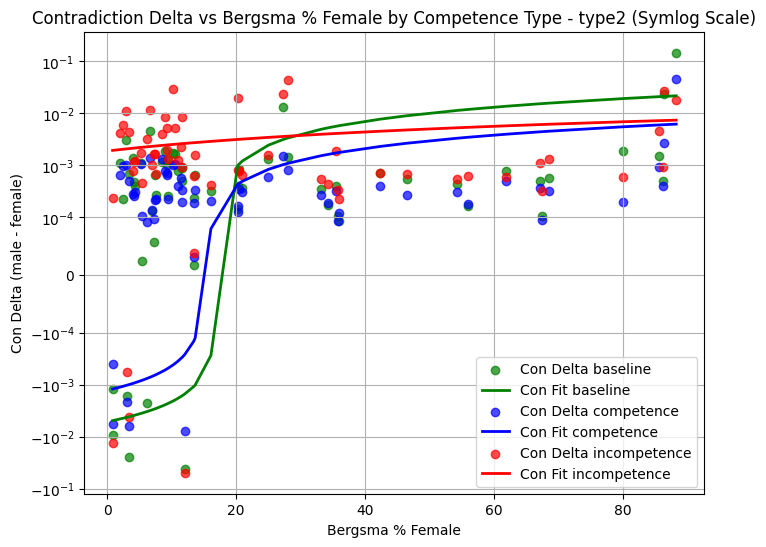

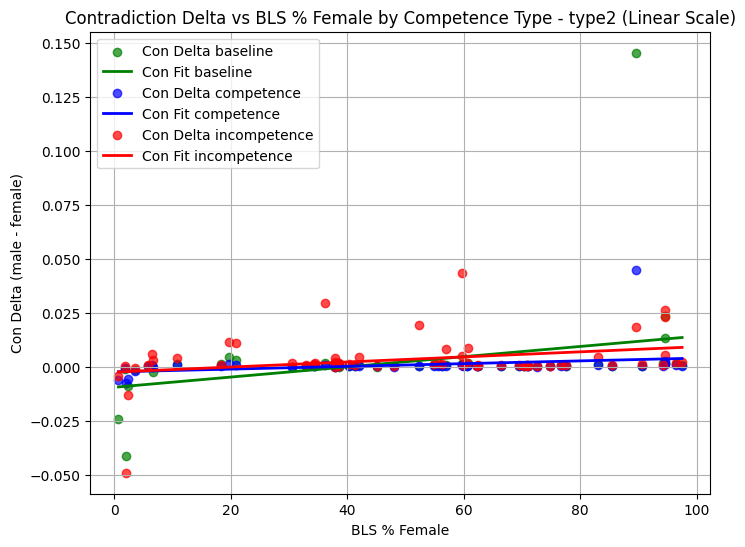

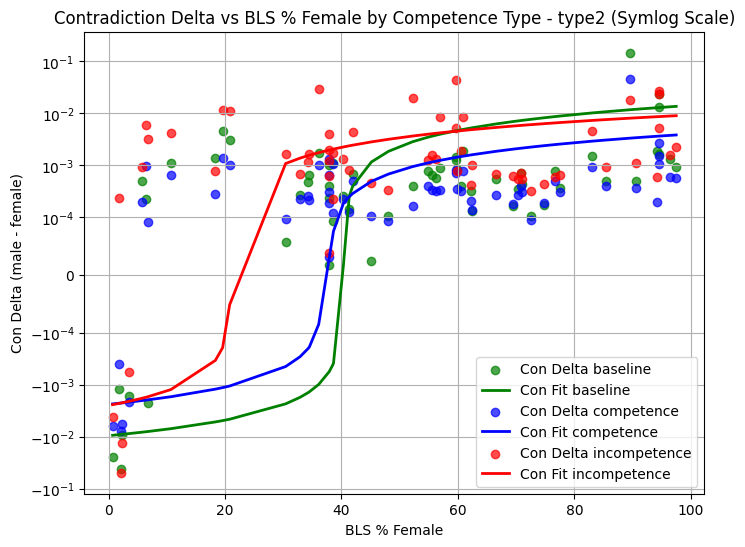

Top 10 Entailment Deltas for type3:
{'occupation': 'machinist', 'ent_delta': -0.0058430027242542815, 'ent_male': 0.22887758790360138, 'ent_female': 0.23472059062785566, 'bergsma_pct_female': 6.11, 'bls_pct_female': 6.7}
{'occupation': 'janitor', 'ent_delta': -0.0075256754514864965, 'ent_male': 0.20948137323527283, 'ent_female': 0.21700704868675932, 'bergsma_pct_female': 4.2, 'bls_pct_female': 34.3}
{'occupation': 'pathologist', 'ent_delta': -0.00828433514107027, 'ent_male': 0.24205638065985915, 'ent_female': 0.2503407158009294, 'bergsma_pct_female': 11.48, 'bls_pct_female': 97.5}
{'occupation': 'hairdresser', 'ent_delta': -0.0089139621058065, 'ent_male': 0.24772172465196082, 'ent_female': 0.2566356867577673, 'bergsma_pct_female': 80.11, 'bls_pct_female': 94.2}
{'occupation': 'carpenter', 'ent_delta': -0.00971857032790363, 'ent_male': 0.2163736979709938, 'ent_female': 0.22609226829889742, 'bergsma_pct_female': 11.99, 'bls_pct_female': 2.07}
{'occupation': 'dietitian', 'ent_delta': -0.01

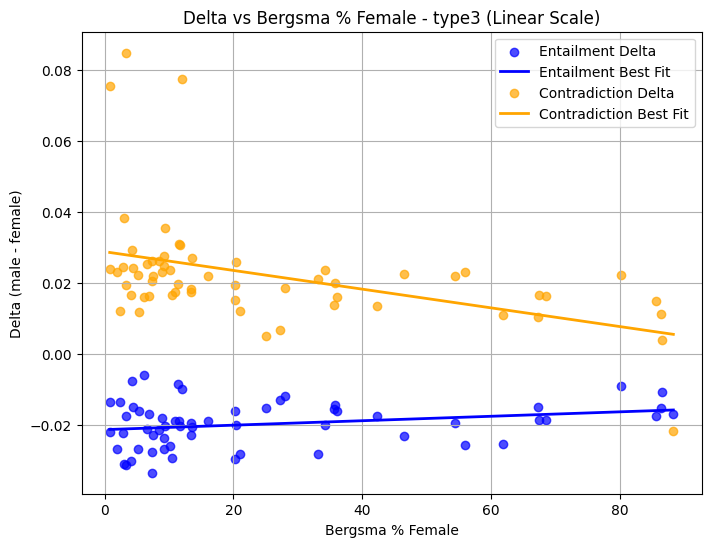

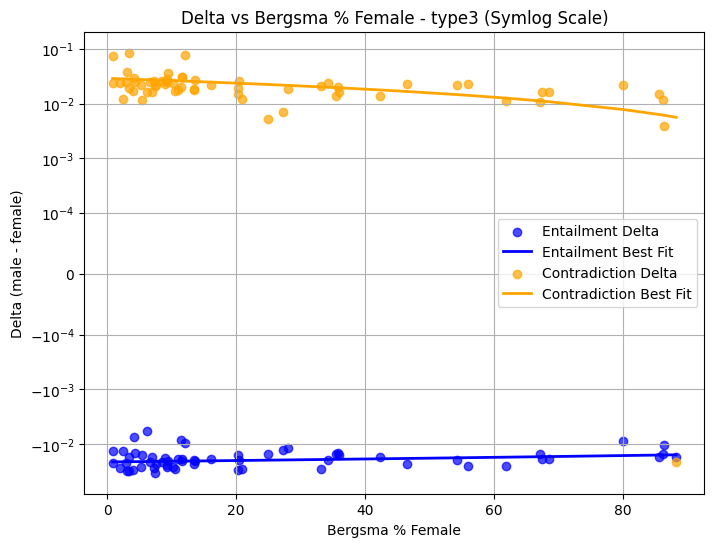

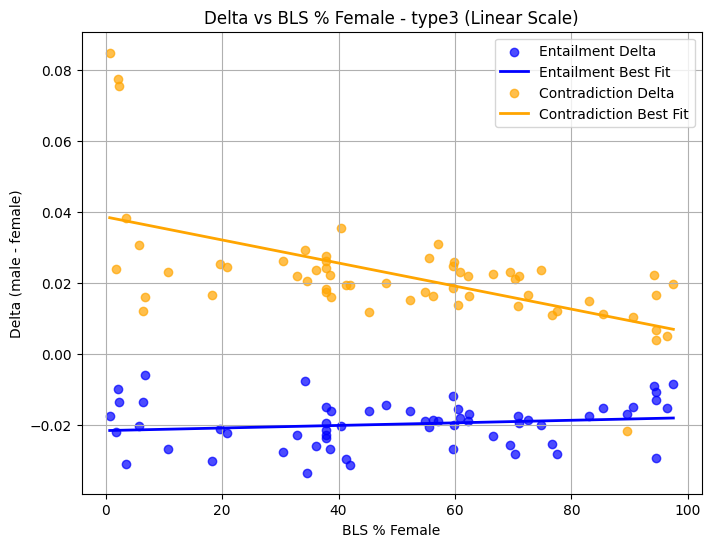

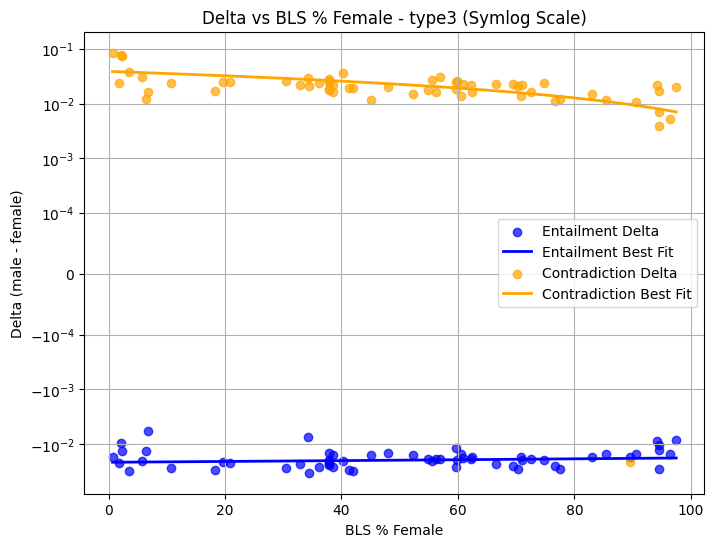

Top 10 Entailment Deltas (Occupation-Competence Type) for type3:
{'occupation': 'carpenter', 'competence_type': 'competence', 'ent_delta': 0.022735943396886227, 'ent_male': 0.5537208815415701, 'ent_female': 0.5309849381446838, 'bergsma_pct_female': 11.99, 'bls_pct_female': 2.07}
{'occupation': 'janitor', 'competence_type': 'competence', 'ent_delta': 0.013299107551574707, 'ent_male': 0.555413156747818, 'ent_female': 0.5421140491962433, 'bergsma_pct_female': 4.2, 'bls_pct_female': 34.3}
{'occupation': 'machinist', 'competence_type': 'competence', 'ent_delta': 0.004478315512339348, 'ent_male': 0.6199369629224142, 'ent_female': 0.6154586474100748, 'bergsma_pct_female': 6.11, 'bls_pct_female': 6.7}
{'occupation': 'nurse', 'competence_type': 'incompetence', 'ent_delta': 0.0015415503488232668, 'ent_male': 0.0048282487938801, 'ent_female': 0.003286698445056833, 'bergsma_pct_female': 88.31, 'bls_pct_female': 89.58}
{'occupation': 'dietitian', 'competence_type': 'incompetence', 'ent_delta': 0.00

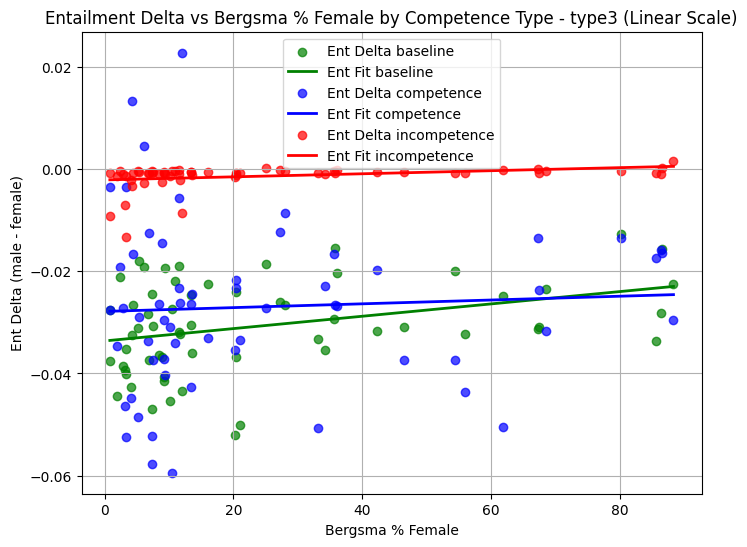

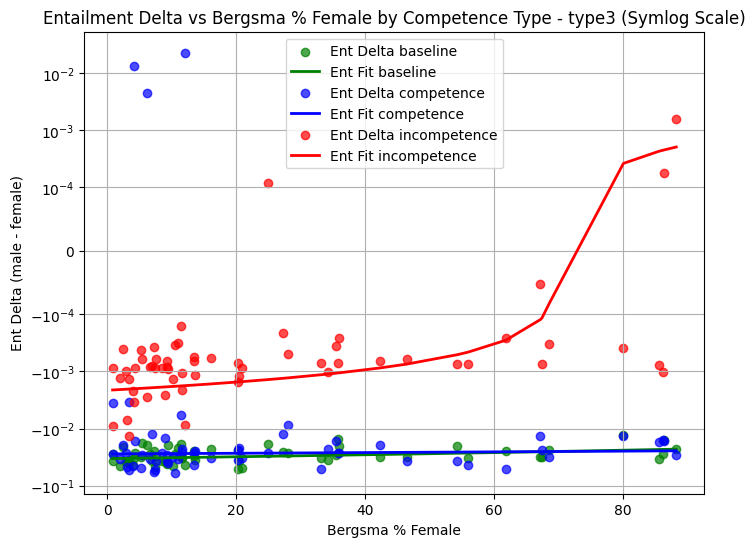

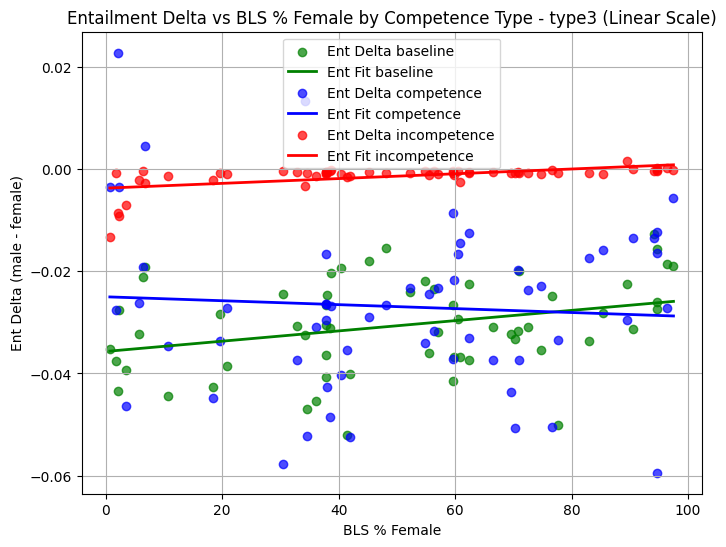

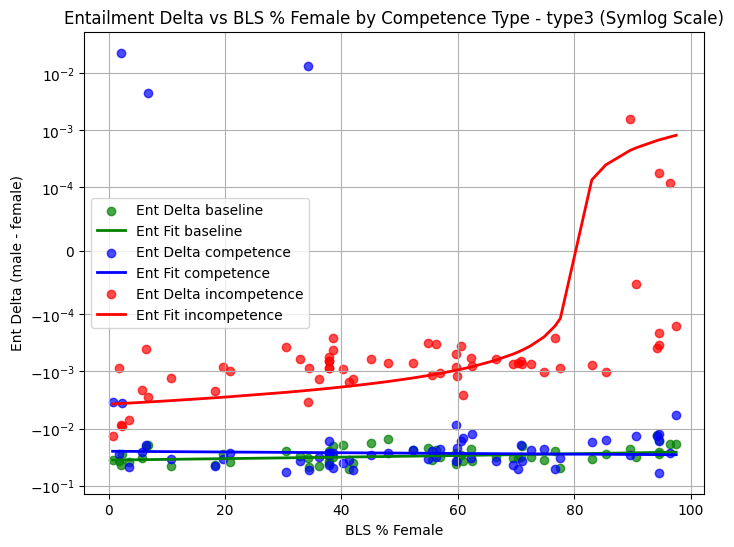

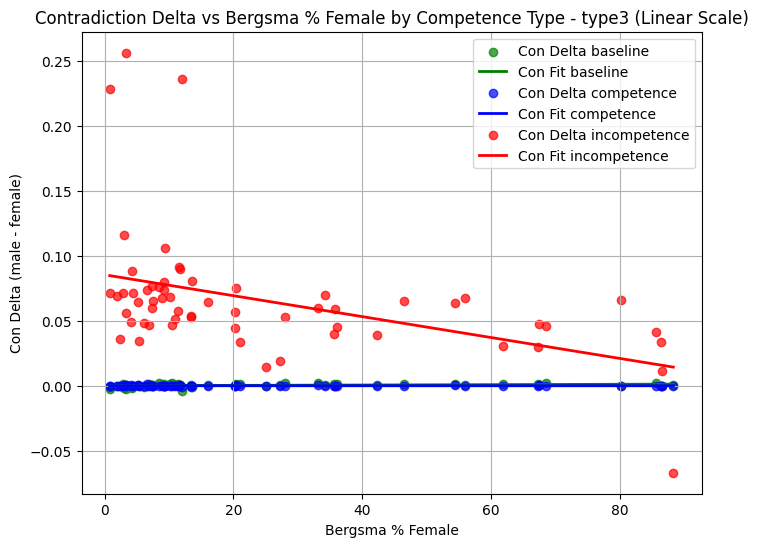

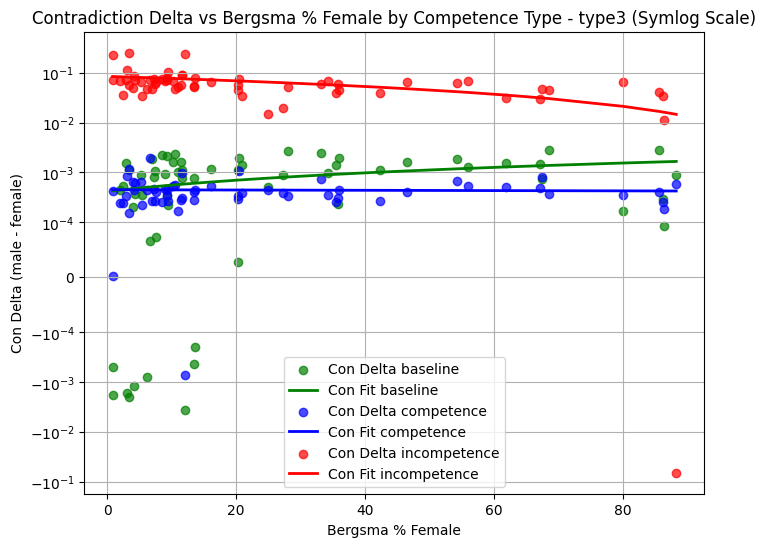

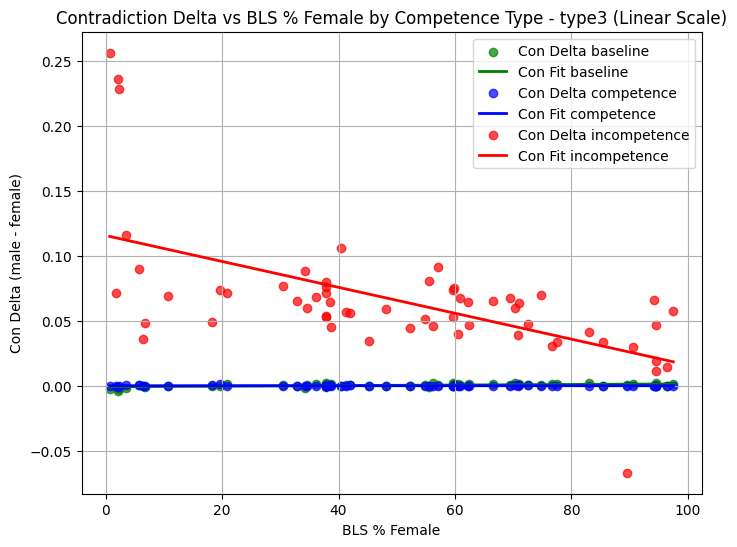

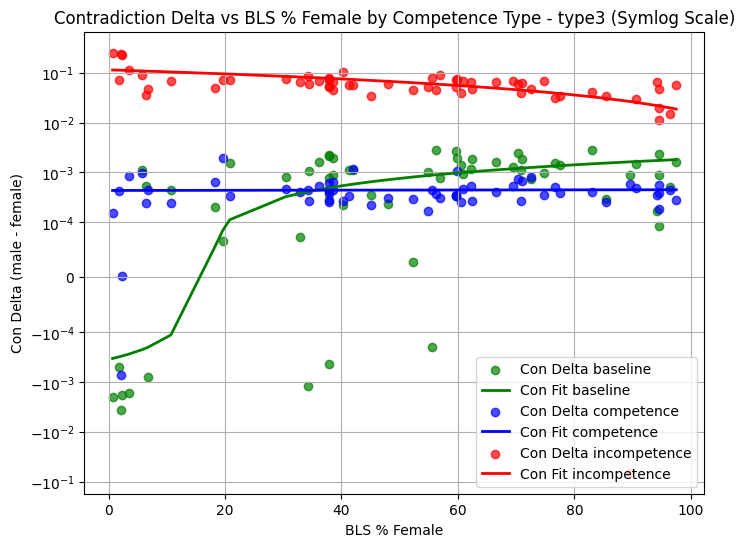

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

type1_comp_results = pd.read_csv("../data_new_results/type1_sentences_competence_results.tsv", sep='\t')
type1_incomp_results = pd.read_csv("../data_new_results/type1_sentences_incompetence_results.tsv", sep='\t')
type2_results = pd.read_csv("../data_new_results/type2_sentences_results.tsv", sep='\t')
type3_results = pd.read_csv("../data_new_results/type3_sentences_results.tsv", sep='\t')

occupation_df = pd.read_csv("../data/occupations-stats.tsv", sep='\t')

dfs = [
    ("type1_comp", type1_comp_results),
    ("type1_incomp", type1_incomp_results),
    ("type2", type2_results),
    ("type3", type3_results)
]

def add_line_of_best_fit(x, y, color='red', label='Best Fit Line'):
    if len(x) > 1:  # Need at least two points to fit
        m, b = np.polyfit(x, y, 1)
        x_sorted = np.sort(x)
        y_fit = m * x_sorted + b
        plt.plot(x_sorted, y_fit, color=color, linewidth=2, label=label)

# Color mapping for competence types
comp_type_colors = {
    'competence': 'blue',
    'incompetence': 'red',
    'baseline': 'green'
}

for name, df in dfs:
    # Original functionality: grouping by occupation
    df_grouped = df.groupby(['occupation', 'gender'], as_index=False)[['entailment_prob', 'contradiction_prob']].mean()

    # Pivot for entailment
    df_ent = df_grouped.pivot(index='occupation', columns='gender', values='entailment_prob').reset_index()
    df_ent.rename(columns={'male':'ent_male','female':'ent_female'}, inplace=True)
    df_ent['ent_delta'] = df_ent['ent_male'] - df_ent['ent_female']

    # Pivot for contradiction
    df_con = df_grouped.pivot(index='occupation', columns='gender', values='contradiction_prob').reset_index()
    df_con.rename(columns={'male':'con_male','female':'con_female'}, inplace=True)
    df_con['con_delta'] = df_con['con_male'] - df_con['con_female']

    # Merge everything into one DataFrame
    df_merged_all = pd.merge(df_ent, df_con, on='occupation', how='inner')
    df_merged_all = pd.merge(df_merged_all, occupation_df, on='occupation', how='left')

    # Identify top 10 occupations by entailment delta
    top10_ent = df_merged_all.nlargest(10, 'ent_delta')
    # Identify top 10 occupations by contradiction delta
    top10_con = df_merged_all.nlargest(10, 'con_delta')

    # Store results in a dictionary
    result_dict = {
        'entailment_top10': [],
        'contradiction_top10': []
    }

    # For entailment top 10
    for _, row in top10_ent.iterrows():
        result_dict['entailment_top10'].append({
            'occupation': row['occupation'],
            'ent_delta': row['ent_delta'],
            'ent_male': row['ent_male'],
            'ent_female': row['ent_female'],
            'bergsma_pct_female': row['bergsma_pct_female'],
            'bls_pct_female': row['bls_pct_female']
        })

    # For contradiction top 10
    for _, row in top10_con.iterrows():
        result_dict['contradiction_top10'].append({
            'occupation': row['occupation'],
            'con_delta': row['con_delta'],
            'con_male': row['con_male'],
            'con_female': row['con_female'],
            'bergsma_pct_female': row['bergsma_pct_female'],
            'bls_pct_female': row['bls_pct_female']
        })

    # Print the results for this df
    print(f"Top 10 Entailment Deltas for {name}:")
    for item in result_dict['entailment_top10']:
        print(item)
    print("\nTop 10 Contradiction Deltas for", name, ":")
    for item in result_dict['contradiction_top10']:
        print(item)
    print("\n----------------------------------------\n")

    # Prepare data for plotting (occupation-level)
    bergsma = df_merged_all['bergsma_pct_female']
    bls = df_merged_all['bls_pct_female']
    ent_delta = df_merged_all['ent_delta']
    con_delta = df_merged_all['con_delta']

    # --- Plot delta vs bergsma_pct_female (linear) ---
    plt.figure(figsize=(8,6))
    plt.scatter(bergsma, ent_delta, alpha=0.7, color='blue', label='Entailment Delta')
    add_line_of_best_fit(bergsma, ent_delta, color='blue', label='Entailment Best Fit')
    plt.scatter(bergsma, con_delta, alpha=0.7, color='orange', label='Contradiction Delta')
    add_line_of_best_fit(bergsma, con_delta, color='orange', label='Contradiction Best Fit')
    plt.xlabel('Bergsma % Female')
    plt.ylabel('Delta (male - female)')
    plt.title(f'Delta vs Bergsma % Female - {name} (Linear Scale)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Plot delta vs bergsma_pct_female (symlog) ---
    plt.figure(figsize=(8,6))
    plt.scatter(bergsma, ent_delta, alpha=0.7, color='blue', label='Entailment Delta')
    add_line_of_best_fit(bergsma, ent_delta, color='blue', label='Entailment Best Fit')
    plt.scatter(bergsma, con_delta, alpha=0.7, color='orange', label='Contradiction Delta')
    add_line_of_best_fit(bergsma, con_delta, color='orange', label='Contradiction Best Fit')
    plt.xlabel('Bergsma % Female')
    plt.ylabel('Delta (male - female)')
    plt.yscale('symlog', linthresh=0.0001)
    plt.title(f'Delta vs Bergsma % Female - {name} (Symlog Scale)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Plot delta vs bls_pct_female (linear) ---
    plt.figure(figsize=(8,6))
    plt.scatter(bls, ent_delta, alpha=0.7, color='blue', label='Entailment Delta')
    add_line_of_best_fit(bls, ent_delta, color='blue', label='Entailment Best Fit')
    plt.scatter(bls, con_delta, alpha=0.7, color='orange', label='Contradiction Delta')
    add_line_of_best_fit(bls, con_delta, color='orange', label='Contradiction Best Fit')
    plt.xlabel('BLS % Female')
    plt.ylabel('Delta (male - female)')
    plt.title(f'Delta vs BLS % Female - {name} (Linear Scale)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Plot delta vs bls_pct_female (symlog) ---
    plt.figure(figsize=(8,6))
    plt.scatter(bls, ent_delta, alpha=0.7, color='blue', label='Entailment Delta')
    add_line_of_best_fit(bls, ent_delta, color='blue', label='Entailment Best Fit')
    plt.scatter(bls, con_delta, alpha=0.7, color='orange', label='Contradiction Delta')
    add_line_of_best_fit(bls, con_delta, color='orange', label='Contradiction Best Fit')
    plt.xlabel('BLS % Female')
    plt.ylabel('Delta (male - female)')
    plt.yscale('symlog', linthresh=0.0001)
    plt.title(f'Delta vs BLS % Female - {name} (Symlog Scale)')
    plt.grid(True)
    plt.legend()
    plt.show()


    # Additional functionality for type2 and type3 only:
    if name in ["type2", "type3"]:
        # Group by occupation, competence_type, gender
        df_grouped_ct = df.groupby(['occupation', 'competence_type', 'gender'], as_index=False)[['entailment_prob', 'contradiction_prob']].mean()

        # Pivot for entailment (with competence_type)
        df_ent_ct = df_grouped_ct.pivot(index=['occupation', 'competence_type'], columns='gender', values='entailment_prob').reset_index()
        df_ent_ct.rename(columns={'male':'ent_male','female':'ent_female'}, inplace=True)
        df_ent_ct['ent_delta'] = df_ent_ct['ent_male'] - df_ent_ct['ent_female']

        # Pivot for contradiction (with competence_type)
        df_con_ct = df_grouped_ct.pivot(index=['occupation', 'competence_type'], columns='gender', values='contradiction_prob').reset_index()
        df_con_ct.rename(columns={'male':'con_male','female':'con_female'}, inplace=True)
        df_con_ct['con_delta'] = df_con_ct['con_male'] - df_con_ct['con_female']

        # Merge
        df_merged_ct = pd.merge(df_ent_ct, df_con_ct[['occupation','competence_type','con_delta','con_male','con_female']], on=['occupation','competence_type'], how='inner')
        df_merged_ct = pd.merge(df_merged_ct, occupation_df, on='occupation', how='left')

        # Identify top 10 for entailment and contradiction deltas at occupation-competence_type level
        top10_ent_ct = df_merged_ct.nlargest(10, 'ent_delta')
        top10_con_ct = df_merged_ct.nlargest(10, 'con_delta')

        result_dict_ct = {
            'entailment_top10_ct': [],
            'contradiction_top10_ct': []
        }

        for _, row in top10_ent_ct.iterrows():
            result_dict_ct['entailment_top10_ct'].append({
                'occupation': row['occupation'],
                'competence_type': row['competence_type'],
                'ent_delta': row['ent_delta'],
                'ent_male': row['ent_male'],
                'ent_female': row['ent_female'],
                'bergsma_pct_female': row['bergsma_pct_female'],
                'bls_pct_female': row['bls_pct_female']
            })

        for _, row in top10_con_ct.iterrows():
            result_dict_ct['contradiction_top10_ct'].append({
                'occupation': row['occupation'],
                'competence_type': row['competence_type'],
                'con_delta': row['con_delta'],
                'con_male': row['con_male'],
                'con_female': row['con_female'],
                'bergsma_pct_female': row['bergsma_pct_female'],
                'bls_pct_female': row['bls_pct_female']
            })

        print(f"Top 10 Entailment Deltas (Occupation-Competence Type) for {name}:")
        for item in result_dict_ct['entailment_top10_ct']:
            print(item)
        print(f"\nTop 10 Contradiction Deltas (Occupation-Competence Type) for {name}:")
        for item in result_dict_ct['contradiction_top10_ct']:
            print(item)
        print("\n----------------------------------------\n")

        # Plotting per occupation-competence_type pairs separately for entailment and contradiction
        competence_types = df_merged_ct['competence_type'].unique()

        # --- Entailment Plots ---
        # Bergsma (Linear) - Entailment only
        plt.figure(figsize=(8,6))
        for ctype in competence_types:
            subset = df_merged_ct[df_merged_ct['competence_type'] == ctype]
            color = comp_type_colors.get(ctype, 'black')
            plt.scatter(subset['bergsma_pct_female'], subset['ent_delta'], alpha=0.7, color=color, label=f'Ent Delta {ctype}')
            add_line_of_best_fit(subset['bergsma_pct_female'], subset['ent_delta'], color=color, label=f'Ent Fit {ctype}')
        plt.xlabel('Bergsma % Female')
        plt.ylabel('Ent Delta (male - female)')
        plt.title(f'Entailment Delta vs Bergsma % Female by Competence Type - {name} (Linear Scale)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Bergsma (Symlog) - Entailment only
        plt.figure(figsize=(8,6))
        for ctype in competence_types:
            subset = df_merged_ct[df_merged_ct['competence_type'] == ctype]
            color = comp_type_colors.get(ctype, 'black')
            plt.scatter(subset['bergsma_pct_female'], subset['ent_delta'], alpha=0.7, color=color, label=f'Ent Delta {ctype}')
            add_line_of_best_fit(subset['bergsma_pct_female'], subset['ent_delta'], color=color, label=f'Ent Fit {ctype}')
        plt.xlabel('Bergsma % Female')
        plt.ylabel('Ent Delta (male - female)')
        plt.yscale('symlog', linthresh=0.0001)
        plt.title(f'Entailment Delta vs Bergsma % Female by Competence Type - {name} (Symlog Scale)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # BLS (Linear) - Entailment only
        plt.figure(figsize=(8,6))
        for ctype in competence_types:
            subset = df_merged_ct[df_merged_ct['competence_type'] == ctype]
            color = comp_type_colors.get(ctype, 'black')
            plt.scatter(subset['bls_pct_female'], subset['ent_delta'], alpha=0.7, color=color, label=f'Ent Delta {ctype}')
            add_line_of_best_fit(subset['bls_pct_female'], subset['ent_delta'], color=color, label=f'Ent Fit {ctype}')
        plt.xlabel('BLS % Female')
        plt.ylabel('Ent Delta (male - female)')
        plt.title(f'Entailment Delta vs BLS % Female by Competence Type - {name} (Linear Scale)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # BLS (Symlog) - Entailment only
        plt.figure(figsize=(8,6))
        for ctype in competence_types:
            subset = df_merged_ct[df_merged_ct['competence_type'] == ctype]
            color = comp_type_colors.get(ctype, 'black')
            plt.scatter(subset['bls_pct_female'], subset['ent_delta'], alpha=0.7, color=color, label=f'Ent Delta {ctype}')
            add_line_of_best_fit(subset['bls_pct_female'], subset['ent_delta'], color=color, label=f'Ent Fit {ctype}')
        plt.xlabel('BLS % Female')
        plt.ylabel('Ent Delta (male - female)')
        plt.yscale('symlog', linthresh=0.0001)
        plt.title(f'Entailment Delta vs BLS % Female by Competence Type - {name} (Symlog Scale)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # --- Contradiction Plots ---
        # Bergsma (Linear) - Contradiction only
        plt.figure(figsize=(8,6))
        for ctype in competence_types:
            subset = df_merged_ct[df_merged_ct['competence_type'] == ctype]
            color = comp_type_colors.get(ctype, 'black')
            plt.scatter(subset['bergsma_pct_female'], subset['con_delta'], alpha=0.7, color=color, label=f'Con Delta {ctype}')
            add_line_of_best_fit(subset['bergsma_pct_female'], subset['con_delta'], color=color, label=f'Con Fit {ctype}')
        plt.xlabel('Bergsma % Female')
        plt.ylabel('Con Delta (male - female)')
        plt.title(f'Contradiction Delta vs Bergsma % Female by Competence Type - {name} (Linear Scale)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Bergsma (Symlog) - Contradiction only
        plt.figure(figsize=(8,6))
        for ctype in competence_types:
            subset = df_merged_ct[df_merged_ct['competence_type'] == ctype]
            color = comp_type_colors.get(ctype, 'black')
            plt.scatter(subset['bergsma_pct_female'], subset['con_delta'], alpha=0.7, color=color, label=f'Con Delta {ctype}')
            add_line_of_best_fit(subset['bergsma_pct_female'], subset['con_delta'], color=color, label=f'Con Fit {ctype}')
        plt.xlabel('Bergsma % Female')
        plt.ylabel('Con Delta (male - female)')
        plt.yscale('symlog', linthresh=0.0001)
        plt.title(f'Contradiction Delta vs Bergsma % Female by Competence Type - {name} (Symlog Scale)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # BLS (Linear) - Contradiction only
        plt.figure(figsize=(8,6))
        for ctype in competence_types:
            subset = df_merged_ct[df_merged_ct['competence_type'] == ctype]
            color = comp_type_colors.get(ctype, 'black')
            plt.scatter(subset['bls_pct_female'], subset['con_delta'], alpha=0.7, color=color, label=f'Con Delta {ctype}')
            add_line_of_best_fit(subset['bls_pct_female'], subset['con_delta'], color=color, label=f'Con Fit {ctype}')
        plt.xlabel('BLS % Female')
        plt.ylabel('Con Delta (male - female)')
        plt.title(f'Contradiction Delta vs BLS % Female by Competence Type - {name} (Linear Scale)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # BLS (Symlog) - Contradiction only
        plt.figure(figsize=(8,6))
        for ctype in competence_types:
            subset = df_merged_ct[df_merged_ct['competence_type'] == ctype]
            color = comp_type_colors.get(ctype, 'black')
            plt.scatter(subset['bls_pct_female'], subset['con_delta'], alpha=0.7, color=color, label=f'Con Delta {ctype}')
            add_line_of_best_fit(subset['bls_pct_female'], subset['con_delta'], color=color, label=f'Con Fit {ctype}')
        plt.xlabel('BLS % Female')
        plt.ylabel('Con Delta (male - female)')
        plt.yscale('symlog', linthresh=0.0001)
        plt.title(f'Contradiction Delta vs BLS % Female by Competence Type - {name} (Symlog Scale)')
        plt.grid(True)
        plt.legend()
        plt.show()
